In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Theory

We have to initialize a Singular Isothermal Sphere (SIS) at equilibrium.

## 1) Positions

For the sampling of $r$, $\phi$ and $\theta$, we can apply the direct Monte Carlo sampling method.\
$\phi$ and $\theta$ are distributed uniformly on the surface of a sphere, so we sample $P \in [0,1]$ and then substitute it in:

$$p(\phi) = \dfrac{1}{2\pi} \:\: \Longrightarrow \:\: P(\phi) \, = \, \int^{\phi}_{0} p(\phi')d\phi' \, = \, \int^{\phi}_{0} \dfrac{1}{2\pi}d\phi' \, = \, \dfrac{\phi}{2\pi} \:\: \Longrightarrow \:\: {\color{lime} \large \phi(P) = 2\pi P} \:\:.$$

$$p(\theta) = \dfrac{\sin{\theta}}{2} \:\: \Longrightarrow \:\: P(\theta) \, = \, \int^{\theta}_{0} p(\theta')d\theta' \, = \, \int^{\theta}_{0} \dfrac{\sin{\theta'}}{2}d\theta' \, = \, \dfrac{1-\cos{\theta}}{2} \:\: \Longrightarrow \:\: {\color{lime} \large \theta(P) = \arccos(1-2P)} \:\:.$$

The sampling of radial positions according to the SIS model is not directly possible, since $\rho(r)$ and $M(r)$ diverge at $r=0$ and $r \rightarrow +\infty$, respectively:
$$\rho(r) \, = \, \dfrac{\sigma^2}{2 \pi G r^2} \:\: , \:\: M(r) \, = \, \dfrac{2 \sigma^2}{G}r \:\:.$$

Let us see how we can work around this problem.

### 1.1) Option 1: boundaries

We can impose $\rho(r) \neq 0$ within $[r_\text{min} , r_\text{max}]$, and null outside:
$$M(r) \, = \, \int^r_{r_\text{min}} \dfrac{\sigma^2}{2 \pi G r'^2} 4 \pi r'^2 dr' \, = \, \dfrac{2 \sigma^2}{G} \int^r_{r_\text{min}} dr' \, = \, \dfrac{2 \sigma^2}{G} \left(r - r_\text{min}\right) \:\: , \:\: M_\text{tot} \, = \, \dfrac{2 \sigma^2}{G} \left(r_\text{max} - r_\text{min}\right) \:\:.$$

</br></br>

- Therefore, the radial *pdf* $p(r)$ is given by:
  $$p(r) \, = \, \dfrac{4\pi r^2 \rho(r)}{M_{tot}} \, = \, \dfrac{2 \sigma^2}{G} \dfrac{1}{M_{tot}} \, = \, \dfrac{1}{r_\text{max} - r_\text{min}} \:\:.$$

</br></br>

- We can integrate it over $r$, obtaining the *cdf* $P(r)$:
  $$P(r) \, = \, \int^{r}_{r_\text{min}} p(r')dr' \, = \, \dfrac{r - r_\text{min}}{r_\text{max} - r_\text{min}} \, = \, \dfrac{M(r)}{M_{tot}} \in [0,1] \:\:.$$

</br></br>

- This relation can be easily inverted:
  $${\color{lime} \large r(P) \, = \, r_\text{min} + \left(r_\text{max} - r_\text{min}\right) P} \:\:.$$

### 1.1) Option 2: modified $\rho(r)$

We can modify $\rho(r)$ to avoid the divergences at $r=0$ and $r \rightarrow +\infty$:
$$\rho(r) \, = \, \dfrac{\sigma^2}{2 \pi G \left(r + r_0\right)^2} e^{-r/R}$$

</br></br>

- Therefore, the radial *pdf* $p(r)$ is given by:
  $${\color{lime} p(r)} \, = \, \dfrac{4\pi r^2 \rho(r)}{M_\text{tot}} {\color{lime} \, \propto \, \dfrac{r^2 e^{-r/R}}{\left(r + r_0\right)^2}} \:\:.$$

</br></br>

- Considering that the integral of $p(r)$ is not trivial, let alone inverting it, we have to resort to acceptance-rejection Monte Carlo.\
  Since $p(r) \neq 0$ for $r \rightarrow +\infty$, we cannot sample from a constant function.\
  A simple alternative is the function $C_\text{norm} e^{-r/R}$, where $C_\text{norm}$ is the normalization constant of $p(r)$.\
  Its cumulative is $P(r) = C_\text{norm} R \left(1 - e^{-r/R}\right)$ and thus $r(P) = -R\ln\left(1 - \frac{P}{C_\text{norm} R}\right)$.

## 2) Velocities

The SIS model has a Maxwellian velocity distribution, where each Cartesian component is indepentent from the others:
$$f(v) d^3 v \, \propto \, exp \left(-\dfrac{v^2}{2\sigma^2}\right) d^3 v \, \propto \, exp \left(-\dfrac{v_x^2 + v_y^2 + v_z^2}{2\sigma^2}\right) dv_x dv_y dv_z \, \propto \, exp \left(-\dfrac{v_x^2}{2\sigma^2}\right) dv_x \:\: exp \left(-\dfrac{v_y^2}{2\sigma^2}\right) dv_y \:\: exp \left(-\dfrac{v_z^2}{2\sigma^2}\right) dv_z \:\:.$$

The velocity distribution does not depend on the position, and thus we can sample each Cartesian component from $p(v_i) \simeq \mathcal{N}(0, \sigma)$.

We still have to determine $\sigma$, which is not a free parameter.\
It would be WRONG to compute it like this:

$$M_\text{tot} \, = \, \int_0^\infty 4\pi r^2 \rho(r) dr \, = \, \dfrac{2 \sigma^2}{G} \int_0^\infty \dfrac{r^2 e^{-r/R}}{\left(r + r_0\right)^2} dr \:\: \Longrightarrow \:\:
\sigma = \sqrt{\dfrac{M_\text{tot} G}{2}} \left(\int_0^\infty \dfrac{r^2 e^{-r/R}}{\left(r + r_0\right)^2} dr\right)^{-1/2} \, = \, \sqrt{\dfrac{M_\text{tot} G C_\text{norm}}{2}} \:\:,$$
because this is a mass-normalization condition and not an equilibrium condition.\
We took $\rho_\text{SIS}(r)$, which assures dynamical equilibrium, and we modified it, obtaining a new $\rho(r)$ that, in general, does not correspond to an equilibrium state.

In general, we could find $\phi(r)$ by solving:
$$\nabla^2 \phi(r) \, = \, \dfrac{1}{r^2} \dfrac{\partial}{\partial r} \left(r^2 \dfrac{\partial \phi(r)}{\partial r}\right) \, = \, 4 \pi G \rho(r) \:\:,$$
we could express $\rho=\rho(\phi)$, and we could use it to solve the Eddington equation to obtain $f(\epsilon)$, but this is not a trivial case.

A more feasible approach is imposing dynamical equilibrium through the virial theorem and deriving $\sigma$ from it:
$$U_\text{tot} = -2K_\text{tot} \simeq -2\dfrac{1}{2} N m v^2 \simeq -3 N m \sigma^2 \:\:, \text{where} \:\: 
U_\text{tot} = \sum_{j > i} - \dfrac{G m_i m_j}{r_{ij}} \:\:.$$

# Code

## 1) Units

In [2]:
G_pu = 6.67430e-8             # cm^3 g^-1 s^-2
r_pu = 3.08567758128e18*1e3   # kpc in cm
m_pu = 1.989e33*1e7           # 10^7 M_sun in g

v_pu = np.sqrt(G_pu * m_pu / r_pu) #cm/s

time_pu = r_pu/v_pu #seconds

E_pu = G_pu*(m_pu**2)/r_pu #cm^2 g s^-2 = erg

In [3]:
v_pu = v_pu/1e5 #km/s
print(f"v_pu/v_iu = {v_pu:.2f} (km/s)/iu")

time_pu = time_pu/(3.156e7*1e6) #megayears
print(f"time_pu/time_iu = {time_pu:.3f} Myr/iu")

print(f"E_pu/E_iu = {E_pu:.2e} erg/iu")

v_pu/v_iu = 6.56 (km/s)/iu
time_pu/time_iu = 149.063 Myr/iu
E_pu/E_iu = 8.56e+51 erg/iu


In [4]:
N = int(5e4+2) # Number of particles
M = 1e4        # Total mass
m = M/(N-2)    # Mass of the single particles

r0 = 0.001     # Softening radius
R = 3.7        # E-folding radius 

## 2) Positions

Sample the angles by using the direct Monte Carlo method

In [5]:
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Sample the radius by using the acceptance-rejection Monte Carlo method

In [ ]:
def pdf(x, C_normalization, r0, R):
    return C_normalization * (x**2)*np.exp(-x/R)/(x+r0)**2

C_normalization = 1/quad(pdf, 0, 1000, args=(1, r0, R))[0]

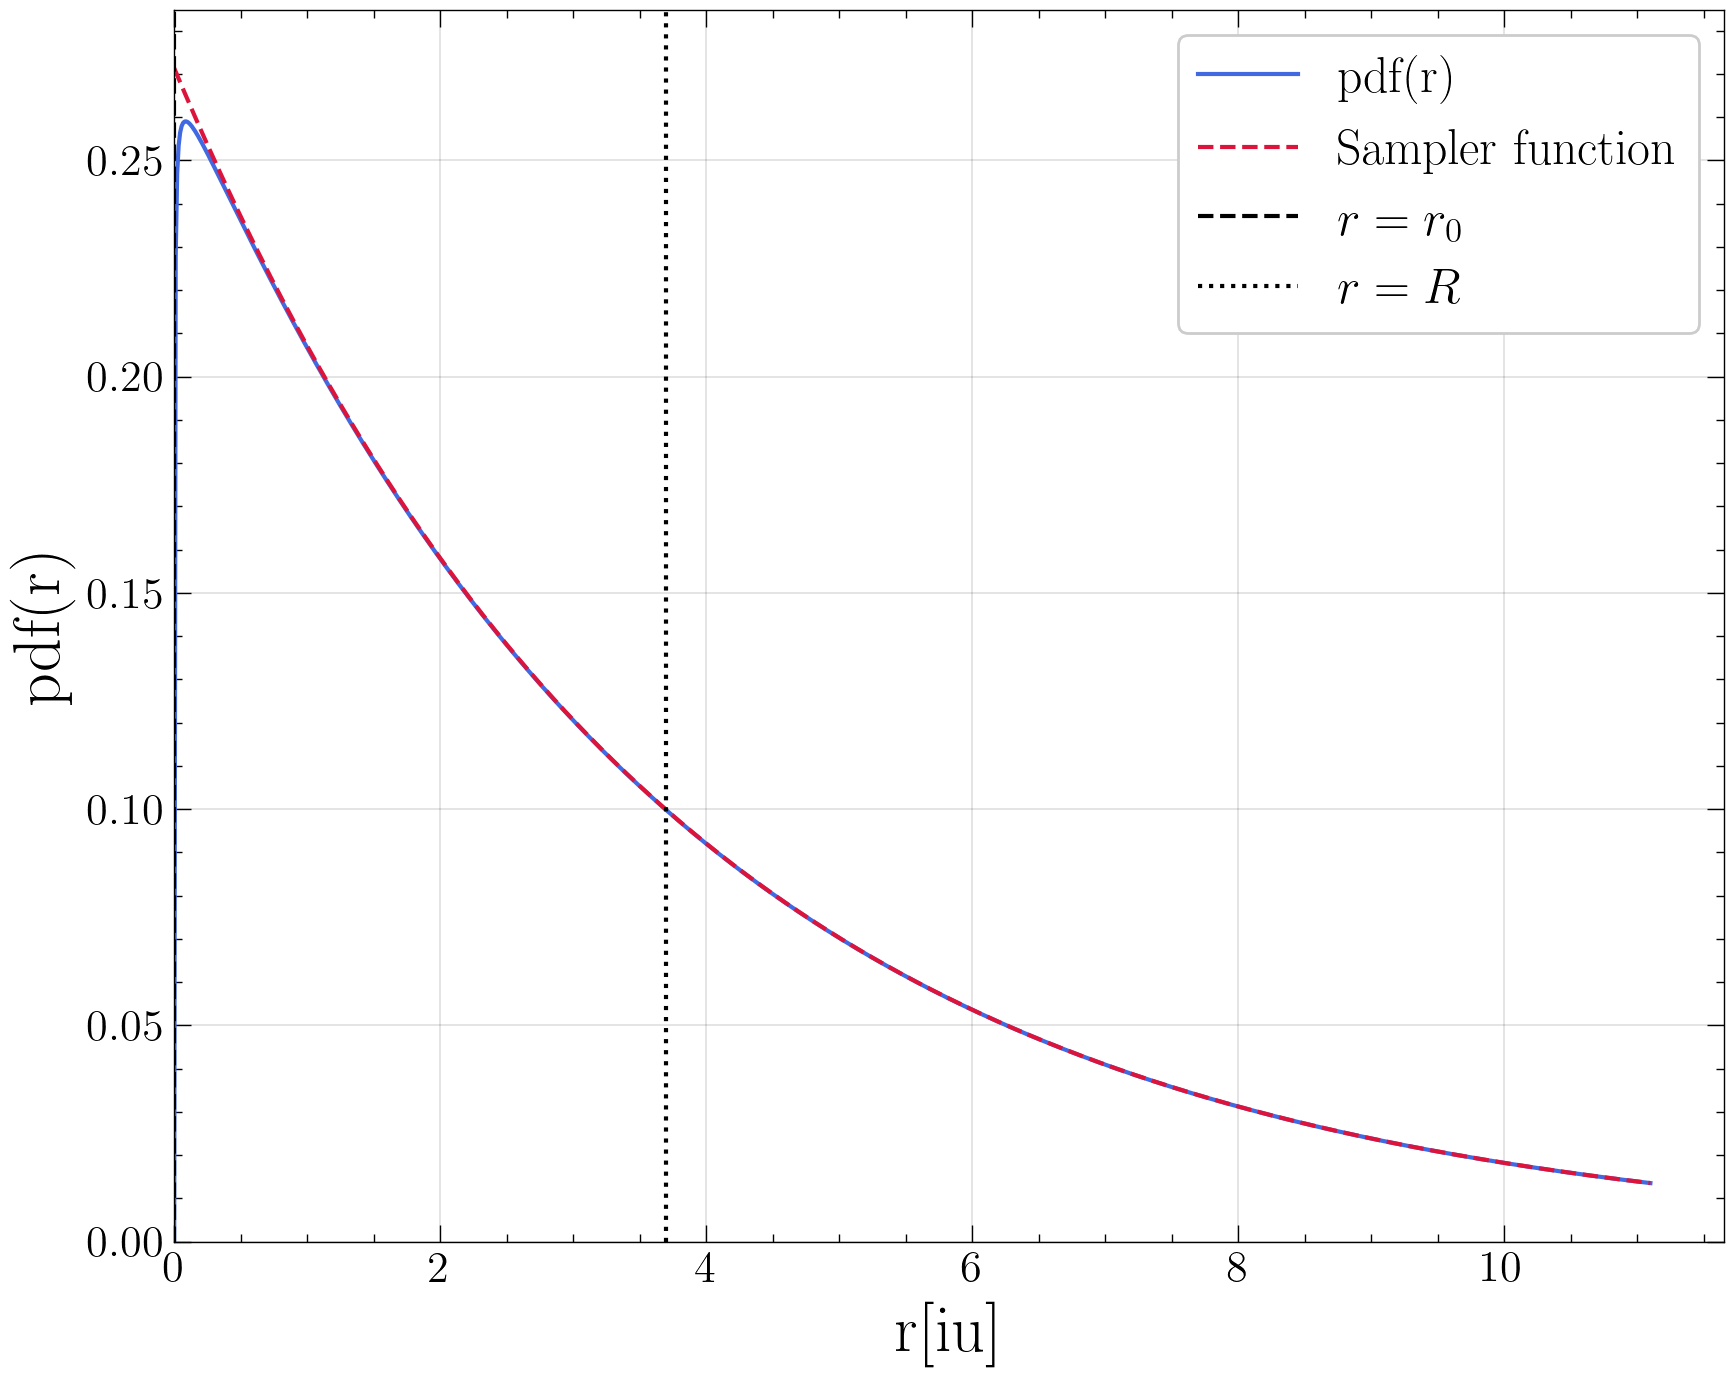

In [7]:
def sampler(x):
    return C_normalization * np.exp(-x/R)

x_dense = np.linspace(0, 3*R, 1000)
plt.plot(x_dense, pdf(x_dense, C_normalization, r0, R), color='royalblue', label='pdf(r)')
plt.plot(x_dense, sampler(x_dense), ls='--', color='crimson', label='Sampler function')
plt.axvline(r0, ls='--', color='black', lw=1.5, label='$r=r_0$')
plt.axvline(R, ls=':', color='black', lw=1.5, label='$r=R$')
plt.xlim(0)
plt.ylim(0)
plt.xlabel('r[iu]')
plt.ylabel('pdf(r)')
plt.legend();

In [ ]:
def AcceptanceRejection(N, f_model, f_sampler):
    sample = np.zeros(N)
    accepted = 0
    
    while accepted<N:
        # To increase efficiency, we sample from the sampler distribution using the inverse transform sampling method.
        # Beware that the sampler distribution is not normalized, and thus its "cumulative" is not confined to 1, but to C_normalization * R
        x = -R * np.log(1 - np.random.uniform(0, C_normalization * R, 1)/(C_normalization * R))
        y = np.random.uniform(0, f_sampler(x), 1)
        if y <= f_model(x, C_normalization, r0, R):
            sample[accepted] = x
            accepted += 1
    return sample

r = AcceptanceRejection(N=N, f_model=pdf, f_sampler=sampler)

Transform from spherical coordinates to Cartesian coordinates

In [9]:
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

Check the *pdfs*

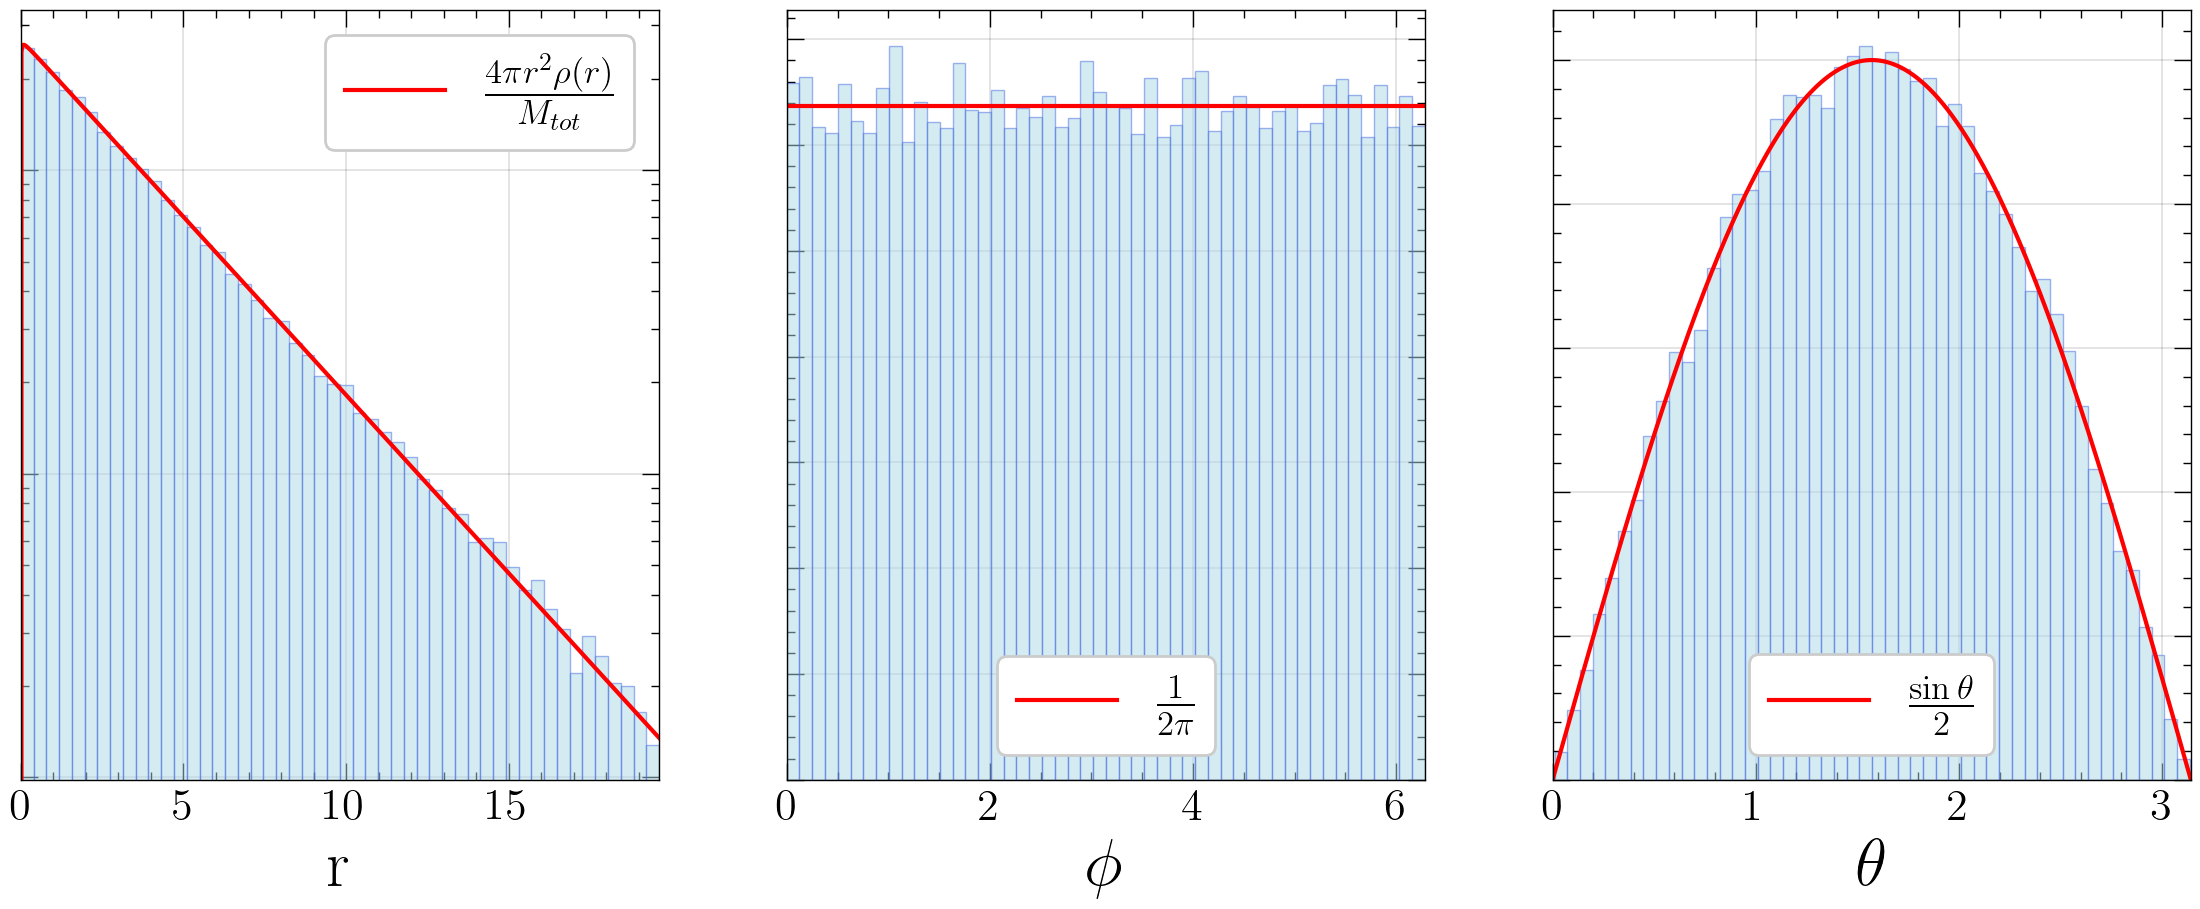

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))

r_max_plot = np.quantile(r, 0.995)
ax = axes[0]
ax.hist(r[r<r_max_plot], bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, r_max_plot, 1000)
ax.plot(x_dense, pdf(x_dense, C_normalization, r0, R), color='red', label='$\\frac{4\pi r^2 \\rho(r)}{M_{tot}}$')
ax.set_xlim(0, r_max_plot)
ax.set_yscale('log')
ax.set_xlabel('r')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[1]
ax.hist(phi, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, 2*np.pi, 1000)
ax.axhline(1/(2*np.pi), color='red', label='$\\frac{1}{2\pi}$')
ax.set_xlim(0, 2*np.pi)
ax.set_xlabel('$\phi$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[2]
ax.hist(theta, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, np.pi, 1000)
ax.plot(x_dense, 0.5*np.sin(x_dense), color='red', label='$\\frac{\sin{\\theta}}{2}$')
ax.set_xlim(0, np.pi)
ax.set_xlabel('$\\theta$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend();

## 3) Add the MBHs and set their initial positions

Since the mass of the perturber must satisfy $M \gg M_{pert} \gg m$, we choose it such that $\frac{M}{M_{pert}} = \frac{M_{pert}}{m}$

$
\begin{cases}
      M = \alpha M_{pert}\\
      M_{pert} = \alpha m\\
      M = mN
\end{cases}
\: \iff \:
\alpha = \dfrac{M}{\sqrt{N}}
$ 

In [11]:
#M_pert = M/np.sqrt(N)
M_pert = (1/100)*M
print(f'M_perturber = {M_pert:.3f}')
print(f'M / M_perturber  = {M/M_pert:.1f}')
print(f'M_perturber / m = {M_pert/m:.1f}')

M_perturber = 100.000
M / M_perturber  = 100.0
M_perturber / m = 500.0


We have to create an array for the masses

In [12]:
masses = m*np.ones(N)
masses[-1] = M_pert
masses[-2] = M_pert

We set the initial position of the perturber such that $r_{pert,0} = {\rm{quantile}}(r; 75\%)$

In [13]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    #The following looks more elegant, but it is less memory-efficient, especially for large arrays
    #return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x[:-2], y[:-2], z[:-2], 0, 0, 0) # It is equal to the array r[:-2]

CMpos_vector = np.array([np.sum(x[:-2]), np.sum(x[:-2]), np.sum(x[:-2])])/(N-2)
CMpos = np.linalg.norm(CMpos_vector)
print(f'CM position = {CMpos:.3f}')

CM position = 0.000


In [14]:
mask = dist_particle<np.quantile(dist_particle, 0.9)
CMpos_q90_vector = np.array([np.sum(x[:-2][mask]), np.sum(y[:-2][mask]), np.sum(z[:-2][mask])])/(N-2)
CMpos_q90 = np.linalg.norm(CMpos_q90_vector)
print(f'CM position 90% = {CMpos_q90:.3f}')

dist_pert = np.quantile(dist_particle, 0.75)
print(f'r_perturber = {dist_pert:.3f}')
print(f'r_perturber - CM position 90% = {dist_pert-CMpos_q90:.3f}')

CM position 90% = 0.013
r_perturber = 5.126
r_perturber - CM position 90% = 5.113


In [15]:
x[-1] = dist_pert
y[-1] = 0
z[-1] = 0

In [16]:
x[-2] = -dist_pert
y[-2] = 0
z[-2] = 0

## 4) Velocities

Compute the potential energy

In [17]:
from scipy.spatial.distance import pdist

positions = np.stack((x[:-2], y[:-2], z[:-2]), axis=1)  # Shape (N-2, 3)
dists = pdist(positions)                                # Only unique pairs
U_tot = -m**2 * np.sum(1.0 / dists)
U_tot

# Incredibly faster than
#U_tot = 0
#for i in tqdm(range(N-2)):
#    for j in range(i+1, N-2):
#        r_ij = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
#        U_tot += -m**2/r_ij

-18431625.36265856

Use the virial theorem to estimate $\sigma$:

$$U = -2K \simeq -2\dfrac{1}{2} N m v^2 \simeq -3 N m \sigma^2$$

In [18]:
sigma = np.sqrt(-U_tot/(3*(N-2)*m))
sigma

24.786841510943233

In [19]:
vx = np.random.normal(0, sigma, N)
vy = np.random.normal(0, sigma, N)
vz = np.random.normal(0, sigma, N)

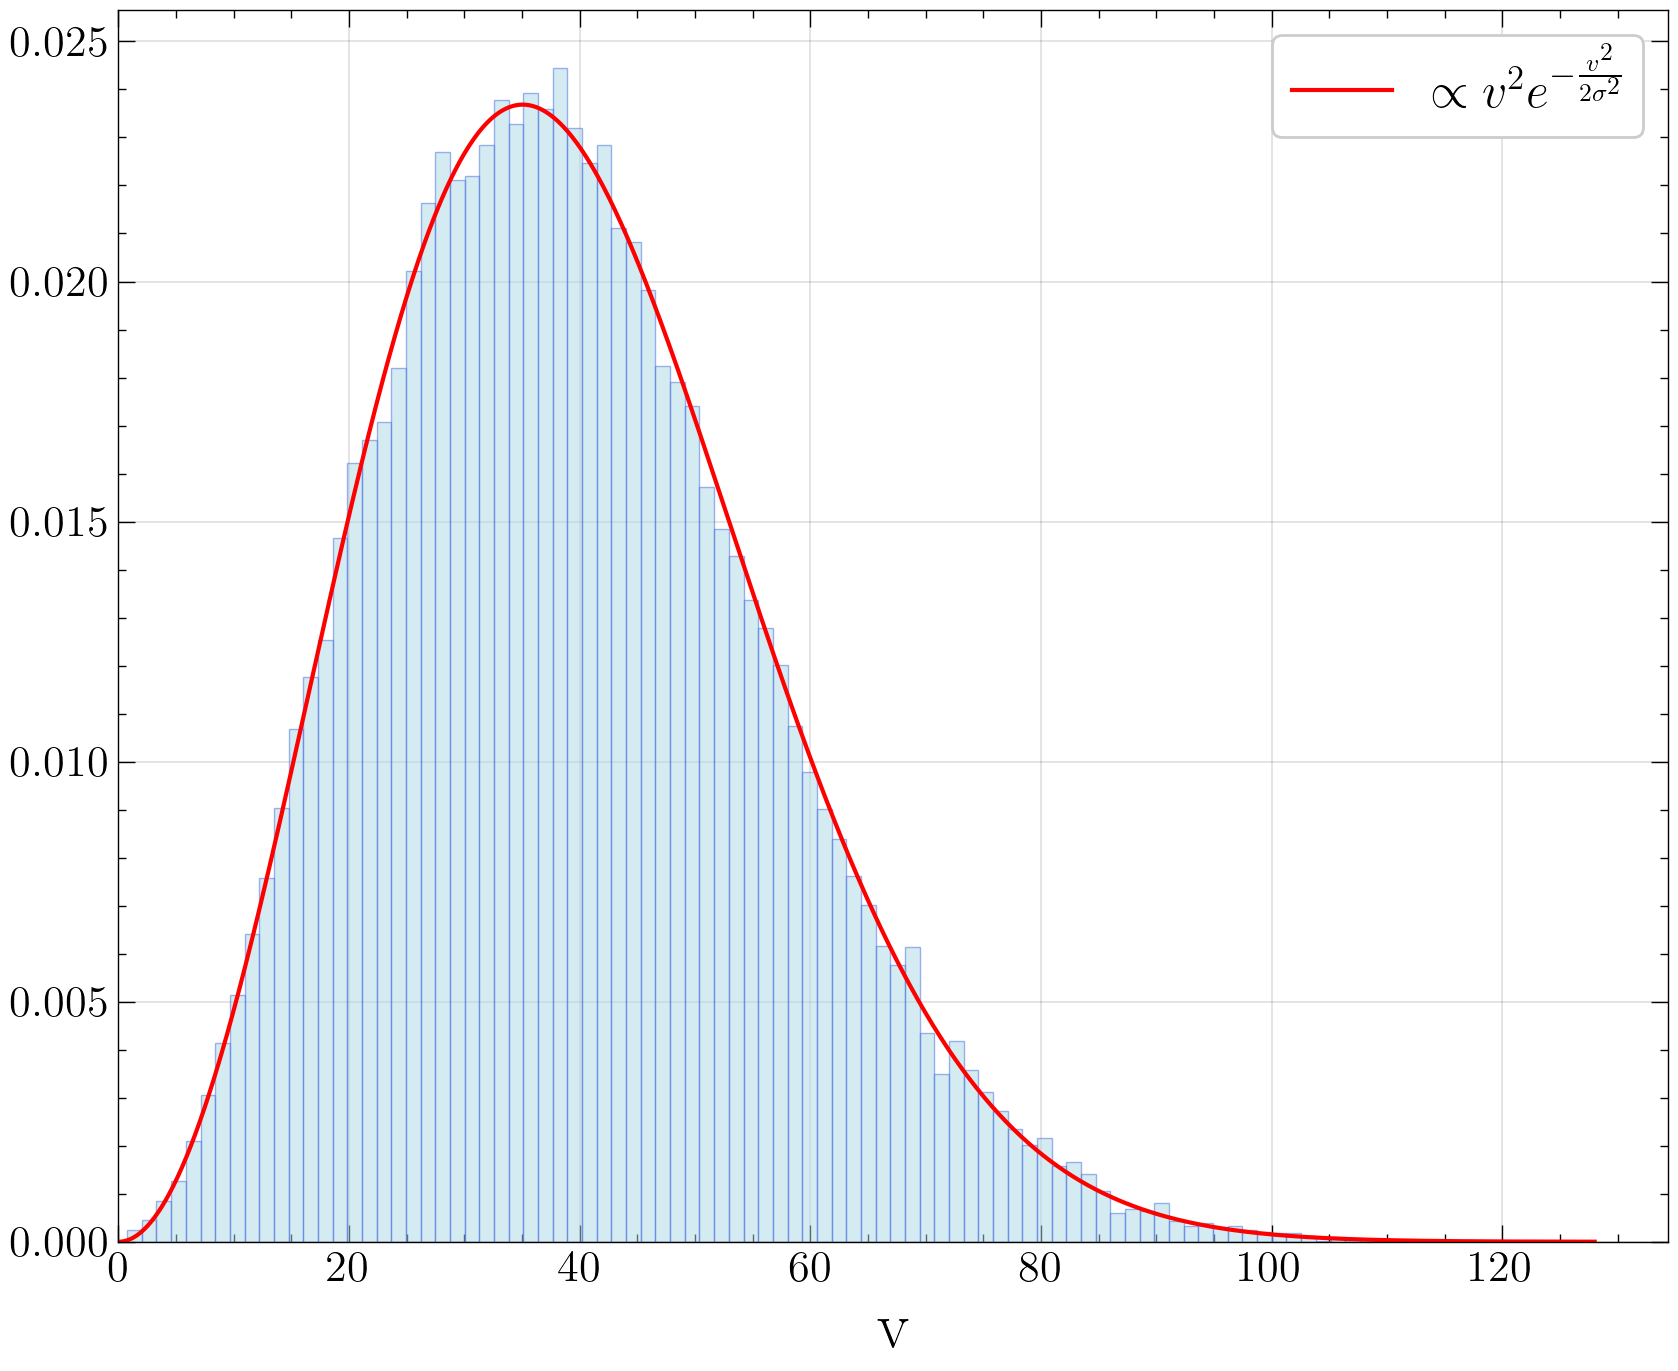

In [20]:
v_norm = np.linalg.norm(np.array([vx, vy, vz]), axis=0)

plt.hist(v_norm, bins=100, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, np.max(v_norm), 1000)
plt.plot(x_dense, np.sqrt(2/np.pi) * x_dense**2 * np.exp(-x_dense**2/(2*sigma**2))/(sigma**3), color='red', label='$\\propto v^2 e^{-\\frac{v^2}{2\sigma^2}}$')
plt.xlim(0)
plt.xlabel('v')
plt.legend();

We can plot the median velocity as a function of radius

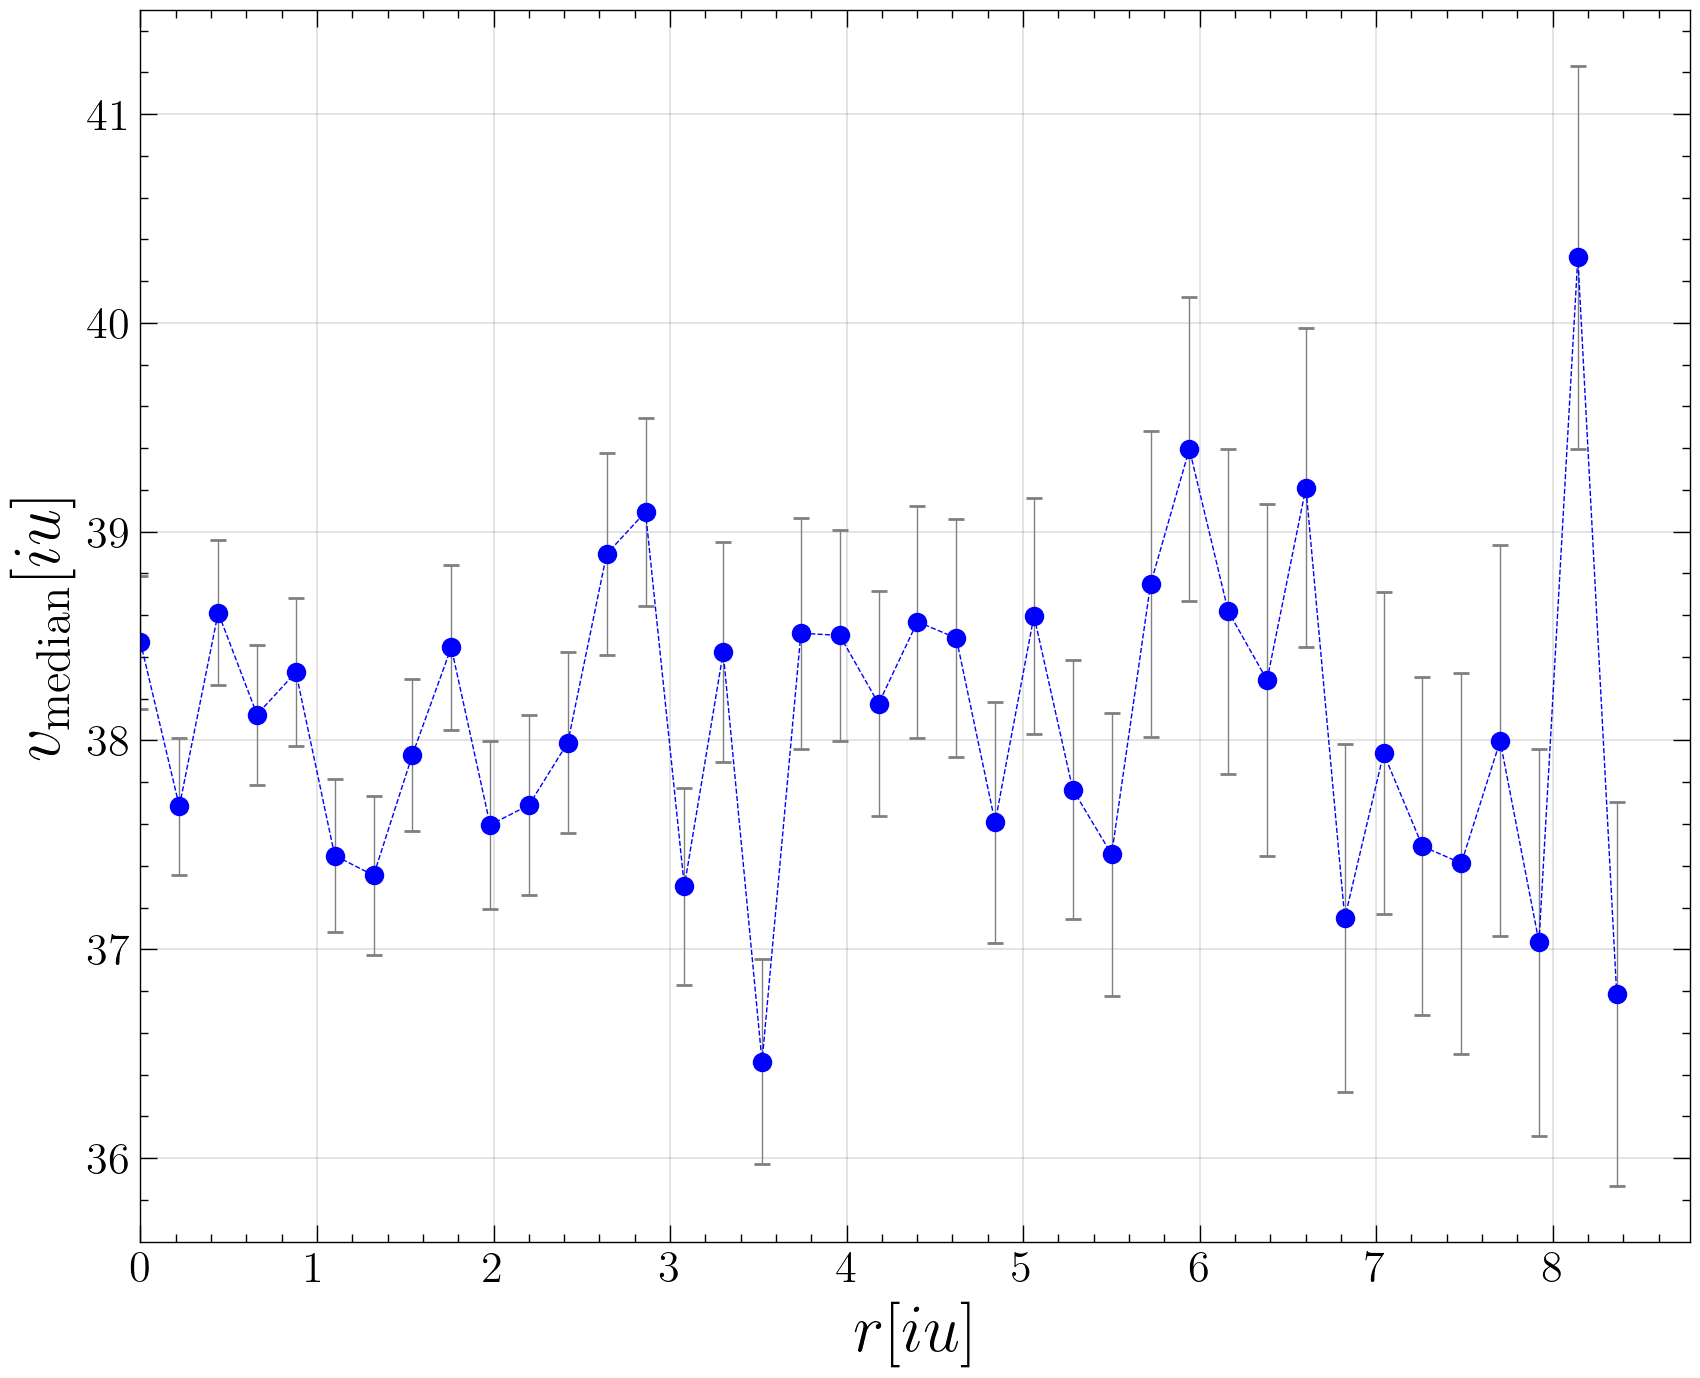

In [21]:
# Redefine the distance from the CM, neglecting the 10% further particles
dist_particle = Dist(x[:-2], y[:-2], z[:-2], CMpos_q90_vector[0], CMpos_q90_vector[1], CMpos_q90_vector[2])

# Define radial bins
r_bins = np.linspace(0, np.quantile(dist_particle, 0.9), 40)

# Compute the median velocity in each radial bin
v = np.sqrt(vx**2 + vy**2 + vz**2)
v_bins = np.zeros_like(r_bins)
v_bins_err = np.zeros_like(r_bins)
for i in range(len(r_bins)-1):
    mask = np.logical_and(dist_particle >= r_bins[i], dist_particle < r_bins[i+1])
    v_bins[i] = np.median(v[:-2][mask])
    v_bins_err[i] = 0.74*(np.quantile(v[:-2][mask], 0.75) - np.quantile(v[:-2][mask], 0.25))/ np.sqrt(np.sum(mask))
    
# Plot the results
plt.errorbar(r_bins[:-1], v_bins[:-1], yerr=v_bins_err[:-1], fmt='o', color='blue', ecolor='grey', capsize=3, capthick=1, ls='--', lw=0.5)
plt.xlim(0)
plt.xlabel('$r[iu]$')
plt.ylabel('$v_\\text{median}[iu]$');

Let us redefine the velocities of the perturbers to have a more reproducible system

In [22]:
v_circ = np.sqrt(m*np.sum(dist_particle < x[-1]) / x[-1])
v_circ

38.241496602236275

In [23]:
vx[-1] = 0
vy[-1] = v_circ
vz[-1] = 0

print(x[-1], y[-1], z[-1])
print(vx[-1], vy[-1], vz[-1])

5.1263253311828185 0.0 0.0
0.0 38.241496602236275 0.0


In [24]:
vx[-2] = 0
vy[-2] = 0
vz[-2] = v_circ

print(x[-2], y[-2], z[-2])
print(vx[-2], vy[-2], vz[-2])

-5.1263253311828185 0.0 0.0
0.0 0.0 38.241496602236275


In [25]:
r_influence = M_pert/sigma**2
print(f'r_influence = {1e3*r_influence:.1f} pc')

r_influence = 162.8 pc


## 5) Create the input file

In [26]:
# open the file
file = open('project.in', 'w')

# write the file
file.write(f'{N}\n')
file.write('3\n')
file.write('0\n')

for i in range(N):
    file.write(f'{masses[i]}\n')

for i in range(N):
    file.write(f'{x[i]} {y[i]} {z[i]}\n')
    
for i in range(N):
    file.write(f'{vx[i]} {vy[i]} {vz[i]}\n')

# close the file
file.close()

## 6) Numerical estimation of some parameters

### 6.1) Softening parameter

In [27]:
r_median = np.quantile(r, 0.5)
r_median

2.5628626978221134

In [28]:
V_at_r_median = (4/3)*np.pi*r_median**3
softening = (V_at_r_median/(N/2))**(1/3)
print(softening)

0.1412870692072045


### 6.2) Dynamical timescale

In [33]:
def Rho(r):
    return sigma**2 / (2*np.pi*(r + r0)**2) * np.exp(-r/R)

rho = Rho(r)
rho_mean = np.mean(rho)
print(f'rho_mean = {rho_mean:.3f}')

rho_mean = 9512.791


In [34]:
t_dyn = np.sqrt(3*np.pi/(16*rho_mean))
print(f't_dyn = {t_dyn:.4f}')

t_dyn = 0.0079
